# Validation
Compare job counts between InteractionLayout, Lookahead routing with transpiled quantum circuit

In [1]:
from lib.interaction_mapping import InteractionMapping

In [2]:
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeLondonV2
from qiskit.transpiler import (
    CouplingMap,
    AnalysisPass,
    TransformationPass,
    Layout,
    PassManager,
    StagedPassManager,
)
from qiskit.transpiler.target import Target
from qiskit.dagcircuit import DAGCircuit, DAGOpNode
from qiskit.transpiler.exceptions import TranspilerError
from qiskit.circuit.library.standard_gates import SwapGate
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.common import (
    generate_embed_passmanager,
    generate_routing_passmanager,
)
from qiskit.converters import circuit_to_dag
from qiskit.visualization import plot_coupling_map, plot_circuit_layout, plot_histogram

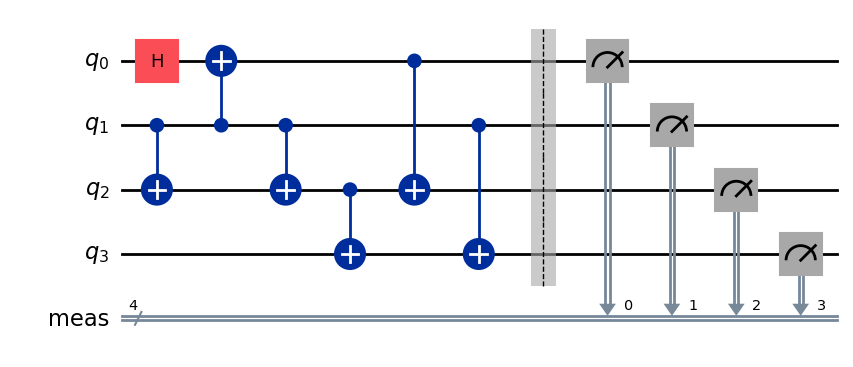

In [4]:
fake_backend = FakeLondonV2()

num_qubits = 4
qc = QuantumCircuit(num_qubits)
qc.h(0)
qc.cx(1, 2)

qc.cx(1, 0)
qc.cx(1, 2)
qc.cx(2, 3)

qc.cx(0, 2)
qc.cx(1, 3)

qc.measure_all()
display(qc.draw("mpl"))

dag = circuit_to_dag(qc)

In [5]:
interaction_mapping = InteractionMapping(
    coupling_map=fake_backend.coupling_map, dag=dag
)
best_layout = interaction_mapping.get_best_qpi_layout()
print("Best mapping layout:", best_layout)

Best mapping layout: [(1, 1), (2, 3), (0, 2), (3, 4)]


In [6]:
class InteractionLayout(AnalysisPass):
    def __init__(self, coupling_map: CouplingMap, initial_map: list[tuple]):
        super().__init__()
        if isinstance(coupling_map, Target):
            self.target = coupling_map
            self.coupling_map = self.target.build_coupling_map()
            self.initial_map = initial_map
        else:
            self.target = None
            self.coupling_map = coupling_map
            self.initial_map = initial_map

    def build_layout(self, map: list[tuple], dag: DAGCircuit) -> Layout:
        cannonical_register = dag.qregs["q"]
        layout = Layout()
        for logical, physical in map:
            layout.add(virtual_bit=cannonical_register[logical], physical_bit=physical)
        return layout

    def run(self, dag: DAGCircuit):
        if self.target is not None:
            if dag.num_qubits() > self.target.num_qubits:
                raise TranspilerError("Number of qubits greater than device.")
        elif dag.num_qubits() > self.coupling_map.size():
            raise TranspilerError("Number of qubits greater than device.")

        layout = self.build_layout(self.initial_map, dag)
        self.property_set["layout"] = layout

        return dag

In [7]:
class DynamicLookaheadSwap(TransformationPass):
    def __init__(self, coupling_map):
        super().__init__()
        if isinstance(coupling_map, Target):
            self.target = coupling_map
            self.coupling_map = self.target.build_coupling_map()
        else:
            self.target = None
            self.coupling_map = coupling_map
        self.dlist = []  # save as index, instead of DAGOpNode
        self.op_gates = []  # save reference of gates

    def list_gates(
        self, dag: DAGCircuit
    ):  # populate gates at current_idx because list(iter(dag.op_nodes())) shuffled because of greedy algorithm
        gate_list = []
        for layer in dag.layers():
            subdag = layer["graph"]
            for node in subdag.op_nodes():
                gate_list.append(node)
        return gate_list

    def list_gates_on_qubit_dag(self, dag: DAGCircuit):
        dependency_list = {qubit: [] for qubit in range(dag.num_qubits())}

        for index, operation in enumerate(dag.op_nodes()):
            qubits = [qubit._index for qubit in operation.qargs]
            for qubit in qubits:  # handle single and two-qubit gate
                dependency_list[qubit].append(index)

        return dependency_list

    def generate_possible_swaps(
        self,
        act_list: list[int],
        coupling_map: CouplingMap,
        current_layout: Layout,
        assigned_swap: list[tuple],
    ):
        candi_list = []
        for act_idx in act_list:
            node = self.op_gates[act_idx]
            phy0, phy1 = (
                current_layout.get_virtual_bits()[node.qargs[0]],
                current_layout.get_virtual_bits()[node.qargs[1]],
            )
            candi_list.extend(
                [
                    (phy0, neighbor)
                    for neighbor in coupling_map.neighbors(phy0)
                    if (phy0, neighbor) not in assigned_swap + candi_list
                    and (neighbor, phy0) not in assigned_swap + candi_list
                ]
            )
            candi_list.extend(
                [
                    (phy1, neighbor)
                    for neighbor in coupling_map.neighbors(phy1)
                    if (phy1, neighbor) not in assigned_swap + candi_list
                    and (neighbor, phy1) not in assigned_swap + candi_list
                ]
            )
        return candi_list

    def calc_effect_gate(
        self,
        node: DAGOpNode,
        swap_nodes: tuple,
        coupling_map: CouplingMap,
        current_layout: Layout,
    ):
        idx0, idx1 = node.qargs[0]._index, node.qargs[1]._index
        phy0, phy1 = (
            current_layout.get_virtual_bits()[node.qargs[0]],
            current_layout.get_virtual_bits()[node.qargs[1]],
        )
        old_distance = self.coupling_map.distance(phy0, phy1)
        if phy0 in swap_nodes:
            phy0 = swap_nodes[1] if phy0 == swap_nodes[0] else swap_nodes[0]
        if phy1 in swap_nodes:
            phy1 = swap_nodes[1] if phy1 == swap_nodes[0] else swap_nodes[0]

        new_distance = coupling_map.distance(phy0, phy1)
        return old_distance - new_distance

    """gate_list = in logical qubit"""

    def sum_effect(
        self,
        gate_list: list[int],
        act_list: list[int],
        swap: tuple,
        coupling_map: CouplingMap,
        current_layout: Layout,
    ):
        is_remove = False
        total_sum = 0
        for gate_idx in gate_list:
            node = self.op_gates[gate_idx]
            if node.op.num_qubits == 2 and node.name not in [
                "barrier",
                "measure",
            ]:  # don't calculate if barrier or measure gate and make sure that only lookahead for two-qubit gates
                value = self.calc_effect_gate(
                    node=node,
                    swap_nodes=swap,
                    coupling_map=coupling_map,
                    current_layout=current_layout,
                )
                if value < 0 and gate_idx in act_list:
                    is_remove = True
                    return total_sum, is_remove
                elif value < 0:
                    break
                elif value == 0 or value == 1:
                    total_sum += value

        return total_sum, is_remove

    def check_gate_connectivity(
        self, act_list: list[int], new_dag: DAGCircuit, current_layout: Layout
    ):
        new_act_list = []
        for act_idx in act_list:
            node = self.op_gates[act_idx]
            idx0, idx1 = (
                node.qargs[0]._index,
                node.qargs[1]._index,
            )  # original gate index
            phy0, phy1 = (
                current_layout.get_virtual_bits()[node.qargs[0]],
                current_layout.get_virtual_bits()[node.qargs[1]],
            )
            distance = self.coupling_map.distance(phy0, phy1)

            if distance == 1:
                self.dlist[idx0].pop(0)
                self.dlist[idx1].pop(0)
                node.qargs = (
                    self.cannonical_register[phy0],
                    self.cannonical_register[phy1],
                )
                new_dag.apply_operation_back(
                    node.op, qargs=node.qargs
                )  # instead of sending gate memory address, send the operation
            else:
                new_act_list.append(act_idx)

        return new_act_list, new_dag

    def measure_node(self, node: DAGOpNode, current_layout: Layout) -> DAGOpNode:
        log0 = current_layout.get_physical_bits()[node.qargs[0]._index]._index
        classical0 = self.property_set["layout"].get_physical_bits()[log0]
        node.cargs = (self.meas_register[classical0._index],)
        return node

    def run(self, dag: DAGCircuit):
        self.dlist = self.list_gates_on_qubit_dag(dag)
        self.op_gates = self.list_gates(dag)

        new_dag = dag.copy_empty_like()

        self.cannonical_register = dag.qregs["q"]
        if dag.cregs:
            self.meas_register = (
                dag.cregs["meas"] if "meas" in dag.cregs else dag.cregs["c"]
            )
        current_layout = Layout.generate_trivial_layout(self.cannonical_register)
        order = current_layout.reorder_bits(new_dag.qubits)

        curr_idx = (
            0  # curr_idx variable to count how many operation gate in the circuit
        )
        for layer in dag.layers():

            subdag = layer["graph"]
            act_list = []
            # initialize first do while with original coupling_map
            for node in subdag.op_nodes():
                if (
                    node.op.num_qubits == 2
                ):  # only check for two-qubit gates, cannot exclude >2 gate because there is barrier
                    new_act_list, new_dag = self.check_gate_connectivity(
                        [curr_idx], new_dag, current_layout
                    )
                    act_list = act_list + new_act_list
                else:
                    if (
                        node.name == "measure"
                    ):  # handle measure node to conform with curr_layout
                        node = self.measure_node(node, current_layout)

                    self.dlist[node.qargs[0]._index].pop(0)
                    new_dag.apply_operation_back(
                        node.op, qargs=node.qargs, cargs=node.cargs
                    )
                curr_idx += 1
            assigned_swap_list = []  # to avoid recursive swap

            while act_list:
                act_list, new_dag = self.check_gate_connectivity(
                    act_list, new_dag, current_layout
                )

                candi_list = self.generate_possible_swaps(
                    act_list, self.coupling_map, current_layout, assigned_swap_list
                )

                MCPE_cost = {}
                for swap in candi_list:
                    log0, log1 = (
                        current_layout.get_physical_bits()[swap[0]]._index,
                        current_layout.get_physical_bits()[swap[1]]._index,
                    )

                    first_total_sum, is_first_remove = self.sum_effect(
                        self.dlist[log0],
                        act_list,
                        swap,
                        self.coupling_map,
                        current_layout,
                    )
                    second_total_sum, is_second_remove = self.sum_effect(
                        self.dlist[log1],
                        act_list,
                        swap,
                        self.coupling_map,
                        current_layout,
                    )

                    if not is_first_remove and not is_second_remove:
                        MCPE_cost[swap] = first_total_sum + second_total_sum

                # check if MCPE is not empty dict
                if MCPE_cost:
                    MCPE_cost = dict(
                        sorted(
                            MCPE_cost.items(), key=lambda item: item[1], reverse=True
                        )
                    )

                    # update CouplingMap with new swap
                    selected_swap, selected_value = next(iter(MCPE_cost.items()))

                    if (
                        selected_value > 0
                    ):  # add check only if worth it to do swap, if not will do recursive swap
                        current_layout.swap(selected_swap[0], selected_swap[1])
                        assigned_swap_list.append(selected_swap)

                        swap_layer = DAGCircuit()
                        swap_layer.add_qreg(self.cannonical_register)
                        swap_log0, swap_log1 = (
                            current_layout.get_physical_bits()[selected_swap[0]],
                            current_layout.get_physical_bits()[selected_swap[1]],
                        )
                        swap_layer.apply_operation_back(
                            SwapGate(), qargs=(swap_log0, swap_log1), cargs=()
                        )

                        order = current_layout.reorder_bits(new_dag.qubits)
                        new_dag.compose(swap_layer, qubits=order)
        return new_dag

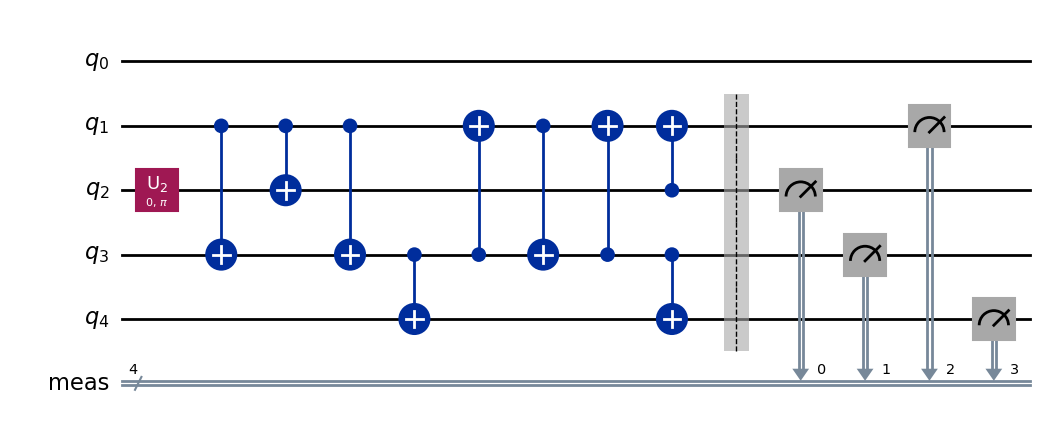

In [8]:
staged_pass = StagedPassManager()

staged_pass.layout = PassManager()
staged_pass.layout += InteractionLayout(
    coupling_map=fake_backend.coupling_map, initial_map=best_layout
)
staged_pass.layout += generate_embed_passmanager(fake_backend.coupling_map)
staged_pass.routing = generate_routing_passmanager(
    DynamicLookaheadSwap(fake_backend.coupling_map), target=fake_backend.coupling_map
)

routing_isa = staged_pass.run(qc).decompose()
display(routing_isa.draw("mpl"))

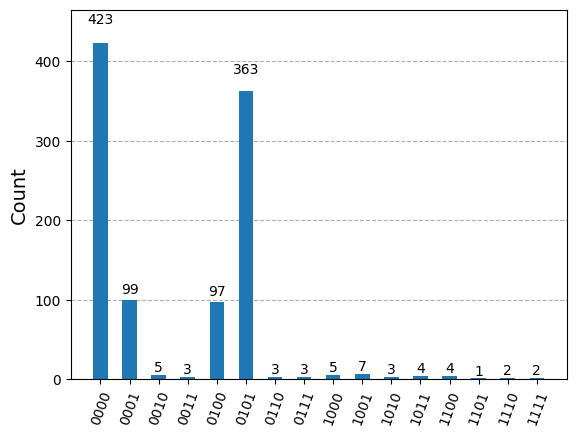

In [10]:
routing_job = fake_backend.run(routing_isa)
routing_counts = routing_job.result().get_counts()
plot_histogram(routing_counts)

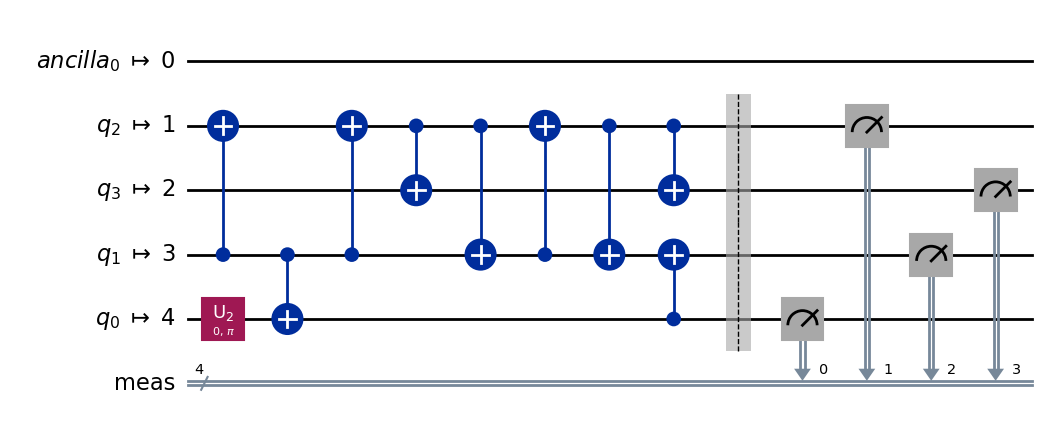

In [11]:
sabre_pass = generate_preset_pass_manager(
    optimization_level=0,
    backend=fake_backend,
    layout_method="sabre",
    routing_method="sabre",
)
sabre_isa = sabre_pass.run(qc)
display(sabre_isa.draw('mpl'))

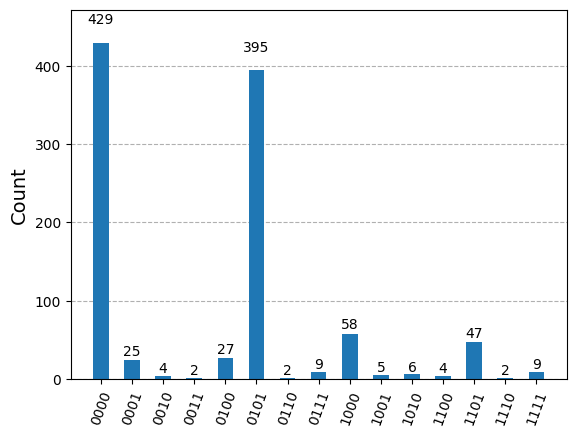

In [12]:
sabre_job = fake_backend.run(sabre_isa)
sabre_counts = sabre_job.result().get_counts()
plot_histogram(sabre_counts)

In [13]:
# Define a threshold for significant occurrence
# For example, here we use 10% of the maximum count as the threshold
def get_most_occurence(counts: dict, threshold_index: float = 0.7) -> list:
    threshold = threshold_index * max(counts.values())

    # Filter the keys based on the threshold
    significant_keys = [key for key, value in counts.items() if value > threshold]
    return significant_keys

In [14]:
# Print the significant keys
sig_routing_counts = get_most_occurence(routing_counts, 0.7)
sig_routing_counts.sort()
sig_sabre_counts = get_most_occurence(sabre_counts, 0.7)
sig_sabre_counts.sort()

print("Significant keys for transpiled counts:", sig_routing_counts)
print("Significant keys for random counts:", sig_sabre_counts)
print("Is the key same:", sig_routing_counts == sig_sabre_counts)

Significant keys for transpiled counts: ['0000', '0101']
Significant keys for random counts: ['0000', '0101']
Is the key same: True
